In [1]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# ppi results
PPI_ACT_PATH = './ppiMatrices'
PPI_SCH_PATH = './ppiMatricesSchaefer'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


In [2]:
import re
from subprocess import call

import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_chisquare, binom_test, proportion_confint
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from scipy.stats import ttest_1samp
from statsmodels.stats.proportion import binom_test

import notebook_functions as nf

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally

In [3]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/PPITest/notebook_functions.py'>

In [4]:
def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [5]:
# pulled from here: https://github.com/psinger/CorrelationStats/blob/c608d8376d765246cd2f0d6b0192507a16bd0901/corrstats.py#L21-L68
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def rho_rxy_rxz(rxy, rxz, ryz):
    num = (ryz-1/2.*rxy*rxz)*(1-pow(rxy,2)-pow(rxz,2)-pow(ryz,2))+pow(ryz,3)
    den = (1 - pow(rxy,2)) * (1 - pow(rxz,2))
    return num/float(den)

def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(xz, n, conf_level=conf_level)[0]
        U2 = rz_ci(xz, n, conf_level=conf_level)[1]
        rho_r12_r13 = rho_rxy_rxz(xy, xz, yz)
        lower = xy - xz - pow((pow((xy - L1), 2) + pow((U2 - xz), 2) - 2 * rho_r12_r13 * (xy - L1) * (U2 - xz)), 0.5)
        upper = xy - xz + pow((pow((U1 - xy), 2) + pow((xz - L2), 2) - 2 * rho_r12_r13 * (U1 - xy) * (xz - L2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

## load the bold qa measures

In [6]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [7]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [8]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [9]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Get the correlation files

In [10]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
ppi_sch_layout = BIDSLayout(PPI_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])
ppi_act_layout = BIDSLayout(PPI_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [11]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [12]:
# activation atlas
ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)


# schaefer atlas
ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)

In [13]:
# ppi activation
ts_act_ppi_switchxrepeat = nf.bind_matrices(ts_act_ppi_objs['switchxrepeat'], "ppi")
fb_act_ppi_switchxrepeat = nf.bind_matrices(fb_act_ppi_objs['switchxrepeat'], "ppi")
ts_act_ppi_dualxsingle = nf.bind_matrices(ts_act_ppi_objs['dualxsingle'], "ppi")
fb_act_ppi_dualxsingle = nf.bind_matrices(fb_act_ppi_objs['dualxsingle'], "ppi")
ts_act_ppi_repeatxsingle = nf.bind_matrices(ts_act_ppi_objs['repeatxsingle'], "ppi")
fb_act_ppi_repeatxsingle = nf.bind_matrices(fb_act_ppi_objs['repeatxsingle'], "ppi")

# ppi schaefer
ts_sch_ppi_switchxrepeat = nf.bind_matrices(ts_sch_ppi_objs['switchxrepeat'], "ppi")
fb_sch_ppi_switchxrepeat = nf.bind_matrices(fb_sch_ppi_objs['switchxrepeat'], "ppi")
ts_sch_ppi_dualxsingle = nf.bind_matrices(ts_sch_ppi_objs['dualxsingle'], "ppi")
fb_sch_ppi_dualxsingle = nf.bind_matrices(fb_sch_ppi_objs['dualxsingle'], "ppi")
ts_sch_ppi_repeatxsingle = nf.bind_matrices(ts_sch_ppi_objs['repeatxsingle'], "ppi")
fb_sch_ppi_repeatxsingle = nf.bind_matrices(fb_sch_ppi_objs['repeatxsingle'], "ppi")


# lss activation
ts_act_lss_switchxrepeat = nf.bind_matrices(ts_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lss_switchxrepeat = nf.bind_matrices(fb_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lss_dualxsingle = nf.bind_matrices(ts_act_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_act_lss_dualxsingle = nf.bind_matrices(fb_act_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_act_lss_repeatxsingle = nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lss_repeatxsingle = nf.bind_matrices(fb_act_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lss schaefer
ts_sch_lss_switchxrepeat = nf.bind_matrices(ts_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lss_switchxrepeat = nf.bind_matrices(fb_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lss_dualxsingle = nf.bind_matrices(ts_sch_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_sch_lss_dualxsingle = nf.bind_matrices(fb_sch_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_sch_lss_repeatxsingle = nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lss_repeatxsingle = nf.bind_matrices(fb_sch_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa activation
ts_act_lsa_switchxrepeat = nf.bind_matrices(ts_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lsa_switchxrepeat = nf.bind_matrices(fb_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lsa_dualxsingle = nf.bind_matrices(ts_act_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_act_lsa_dualxsingle = nf.bind_matrices(fb_act_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_act_lsa_repeatxsingle = nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lsa_repeatxsingle = nf.bind_matrices(fb_act_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa schaefer
ts_sch_lsa_switchxrepeat = nf.bind_matrices(ts_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lsa_switchxrepeat = nf.bind_matrices(fb_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lsa_dualxsingle = nf.bind_matrices(ts_sch_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_dualxsingle[['participant_id', 'task']] = ts_sch_ppi_dualxsingle[['participant_id', 'task']]
fb_sch_lsa_dualxsingle = nf.bind_matrices(fb_sch_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_dualxsingle[['participant_id', 'task']] = ts_sch_ppi_dualxsingle[['participant_id', 'task']]

ts_sch_lsa_repeatxsingle = nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lsa_repeatxsingle = nf.bind_matrices(fb_sch_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]

In [14]:
len(fb_sch_ppi_switchxrepeat)

40

In [15]:
np.corrcoef(ts_sch_ppi_repeatxsingle.mean(axis=0).values, ts_sch_lss_repeatxsingle.mean(axis=0).values)

array([[1.        , 0.61467669],
       [0.61467669, 1.        ]])

In [16]:
ts_act_lsa_repeatxsingle_mean = ts_act_lsa_repeatxsingle.mean(axis=0).values
ts_act_lss_repeatxsingle_mean = ts_act_lss_repeatxsingle.mean(axis=0).values
ts_act_ppi_repeatxsingle_mean = ts_act_ppi_repeatxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_repeatxsingle_mean, ts_act_lss_repeatxsingle_mean, ts_act_ppi_repeatxsingle_mean])

array([[1.        , 0.28734264, 0.19827265],
       [0.28734264, 1.        , 0.56697634],
       [0.19827265, 0.56697634, 1.        ]])

In [17]:
ts_act_lsa_switchxrepeat_mean = ts_act_lsa_switchxrepeat.mean(axis=0).values
ts_act_lss_switchxrepeat_mean = ts_act_lss_switchxrepeat.mean(axis=0).values
ts_act_ppi_switchxrepeat_mean = ts_act_ppi_switchxrepeat.mean(axis=0).values
np.corrcoef([ts_act_lsa_switchxrepeat_mean, ts_act_lss_switchxrepeat_mean, ts_act_ppi_switchxrepeat_mean])

array([[1.        , 0.30559026, 0.23456179],
       [0.30559026, 1.        , 0.45726016],
       [0.23456179, 0.45726016, 1.        ]])

In [18]:
ts_act_lsa_dualxsingle_mean = ts_act_lsa_dualxsingle.mean(axis=0).values
ts_act_lss_dualxsingle_mean = ts_act_lss_dualxsingle.mean(axis=0).values
ts_act_ppi_dualxsingle_mean = ts_act_ppi_dualxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_dualxsingle_mean, ts_act_lss_dualxsingle_mean, ts_act_ppi_dualxsingle_mean])

array([[1.        , 0.30498854, 0.20166615],
       [0.30498854, 1.        , 0.59099154],
       [0.20166615, 0.59099154, 1.        ]])

## Prep for analysis

In [19]:
# collect permutations and number of significant values found for each condition
result_collector = {
    'atlas': [],
    'data': [],
    'contrast': [],
    'estimator': [],
    'participants': [],
    'observed_value': [],
    'binom_p_value': [],
    'corr_t': [],
    'corr_p': [],
}

correlation_collector = {
    "atlas": [],
    "data": [],
    "contrast": [],
    "participants": [],
    "lssxppi": [],
    "lsaxppi": [],
    "lsaxlss": [],
    "corr_t": [],
    "corr_p": [],
}

In [20]:
# load coordinate table for clusters:
# for making activation atlas glass brain images
coords_df = pd.read_csv('../firstLevelAnalysis/outputs/cluster_table.tsv', sep='\t')

In [21]:
def analyze_data(ppi_contrast, lss_contrast, lsa_contrast, data, result_collector, correlation_collector,
                 contrast, atlas, coords_df, best_regions=None, best_regions_orig=None, create_brain_fig=True):
    
    
    fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
        ppi_contrast, lss_contrast, lsa_contrast,
        rois=atlas, nthreads=N_THREADS, use_python=True)
    
    if atlas == "activation":
        fig_brain = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
        atlas_name = atlas.title()
        atlas_fname = atlas
    elif atlas == "schaefer" and best_regions:
        fig_brain = nf.make_glass_brain(
            overlap_lss_df.loc[best_regions, best_regions],
            coords_df,
            annotate_nodes=False,
            color_nodes=True,
            cbar_ticks=["LSS", "PPI", "Both"]
        )
        atlas_name = (atlas + " (Top 20 {})").title().format("ROIs")
        atlas_fname = ''.join([atlas, "best"])
    else:
        atlas_fname = altas
    
    if create_brain_fig:
        contrast_name = contrast.replace('x', ' - ').title()
        title_tmp = "{atlas} Atlas: {contrast} ({data} Data)"
        title = title_tmp.format(atlas=atlas_name, contrast=contrast_name, data=data.title())
        fig_brain.suptitle(title, size=30, weight='heavy')
        eps_tmp = './outputs/data-{data}_type-brain_atlas-{atlas}_contrast-{contrast}_compare-lssxppi'
        outfile = eps_tmp.format(data=data, atlas=atlas_fname, contrast=contrast)
        save_eps(fig_brain, outfile)
    

    if best_regions and best_regions_orig:
        bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

        ppi_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
        lss_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
        lsa_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
        
        ppi_len = len(ppi_model_df['p_value'][bool_query])
        lss_len = len(lss_model_df['p_value'][bool_query])
        lsa_len = len(lsa_model_df['p_value'][bool_query])
        
        corr_mat = np.corrcoef([lsa_model_df["estimate"][bool_query],
                                lss_model_df["estimate"][bool_query],
                                ppi_model_df["estimate"][bool_query]])
        lsa_lss_corr = corr_mat[1, 0]
        lsa_ppi_corr = corr_mat[2, 0]
        lss_ppi_corr = corr_mat[2, 1]
        
        print("Schaefer Top 20")
        print(corr_mat)

        corr_t, corr_p = dependent_corr(lss_ppi_corr, lsa_ppi_corr, lsa_lss_corr, len(lsa_model_df["estimate"][bool_query]))
    else:
        ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
        lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
        lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)
        ppi_len = len(ppi_model_df['p_value'])
        lss_len = len(lss_model_df['p_value'])
        lsa_len = len(lsa_model_df['p_value'])
        
        corr_mat = np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])
        lsa_lss_corr = corr_mat[1, 0]
        lsa_ppi_corr = corr_mat[2, 0]
        lss_ppi_corr = corr_mat[2, 1]

        print(corr_mat)

        corr_t, corr_p = dependent_corr(lss_ppi_corr, lsa_ppi_corr, lsa_lss_corr, len(lsa_model_df["estimate"]))

    
    correlation_collector['atlas'].append(atlas_fname)
    correlation_collector['data'].append(data)
    correlation_collector['contrast'].append(contrast)
    correlation_collector['participants'].append('filtered')
    correlation_collector["lssxppi"].append(lss_ppi_corr)
    correlation_collector["lsaxppi"].append(lsa_ppi_corr)
    correlation_collector["lsaxlss"].append(lsa_lss_corr)
    correlation_collector["corr_t"].append(corr_t)
    correlation_collector["corr_p"].append(corr_p)
    
    
    # PPI
    result_collector['atlas'].append(atlas_fname)
    result_collector['data'].append(data)
    result_collector['contrast'].append(contrast)
    result_collector['participants'].append('filtered')
    result_collector['estimator'].append('ppi')
    result_collector['observed_value'].append(ppi_sig)
    result_collector['binom_p_value'].append(binom_test(ppi_sig, ppi_len, prop=0.05, alternative='larger'))
    result_collector['corr_t'].append(corr_t)
    result_collector['corr_p'].append(corr_p)

    # LSS
    result_collector['atlas'].append(atlas_fname)
    result_collector['data'].append(data)
    result_collector['contrast'].append(contrast)
    result_collector['participants'].append('filtered')
    result_collector['estimator'].append('lss')
    result_collector['observed_value'].append(lss_sig)
    result_collector['binom_p_value'].append(binom_test(lss_sig, lss_len, prop=0.05, alternative='larger'))
    result_collector['corr_t'].append(corr_t)
    result_collector['corr_p'].append(corr_p)

    # LSA
    result_collector['atlas'].append(atlas_fname)
    result_collector['data'].append(data)
    result_collector['contrast'].append(contrast)
    result_collector['participants'].append('filtered')
    result_collector['estimator'].append('lsa')
    result_collector['observed_value'].append(lsa_sig)
    result_collector['binom_p_value'].append(binom_test(lsa_sig, lsa_len, prop=0.05, alternative='larger'))
    result_collector['corr_t'].append(corr_t)
    result_collector['corr_p'].append(corr_p)

    if atlas == "schaefer":
        ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
        lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
        lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)
        ppi_len = len(ppi_model_df['p_value'])
        lss_len = len(lss_model_df['p_value'])
        lsa_len = len(lsa_model_df['p_value'])
        
        corr_mat = np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])
        lsa_lss_corr = corr_mat[1, 0]
        lsa_ppi_corr = corr_mat[2, 0]
        lss_ppi_corr = corr_mat[2, 1]
        
        print("Schaefer Full")
        print(corr_mat)

        corr_t, corr_p = dependent_corr(lss_ppi_corr, lsa_ppi_corr, lsa_lss_corr, len(lsa_model_df["estimate"]))
        
        correlation_collector['atlas'].append(atlas)
        correlation_collector['data'].append(data)
        correlation_collector['contrast'].append(contrast)
        correlation_collector['participants'].append('filtered')
        correlation_collector["lssxppi"].append(lss_ppi_corr)
        correlation_collector["lsaxppi"].append(lsa_ppi_corr)
        correlation_collector["lsaxlss"].append(lsa_lss_corr)
        correlation_collector["corr_t"].append(corr_t)
        correlation_collector["corr_p"].append(corr_p)
        # PPI
        result_collector['atlas'].append(atlas)
        result_collector['data'].append(data)
        result_collector['contrast'].append(contrast)
        result_collector['participants'].append('filtered')
        result_collector['estimator'].append('ppi')
        result_collector['observed_value'].append(ppi_sig)
        result_collector['binom_p_value'].append(binom_test(ppi_sig, ppi_len, prop=0.05, alternative='larger'))
        result_collector['corr_t'].append(corr_t)
        result_collector['corr_p'].append(corr_p)

        # LSS
        result_collector['atlas'].append(atlas)
        result_collector['data'].append(data)
        result_collector['contrast'].append(contrast)
        result_collector['participants'].append('filtered')
        result_collector['estimator'].append('lss')
        result_collector['observed_value'].append(lss_sig)
        result_collector['binom_p_value'].append(binom_test(lss_sig, lss_len, prop=0.05, alternative='larger'))
        result_collector['corr_t'].append(corr_t)
        result_collector['corr_p'].append(corr_p)

        # LSA
        result_collector['atlas'].append(atlas)
        result_collector['data'].append(data)
        result_collector['contrast'].append(contrast)
        result_collector['participants'].append('filtered')
        result_collector['estimator'].append('lsa')
        result_collector['observed_value'].append(lsa_sig)
        result_collector['binom_p_value'].append(binom_test(lsa_sig, lsa_len, prop=0.05, alternative='larger'))
        result_collector['corr_t'].append(corr_t)
        result_collector['corr_p'].append(corr_p)
        

## Activation Atlas: Dual - Single (Real Data)

Number of Positives lsa: 9 / 210
Number of Positives ppi: 22 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 19 / 210
Number of Positives ppi: 22 / 210
Number of overlapping positives: 4 / 210


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(axes, collections.Sequence):


[[1.         0.30851438 0.22017502]
 [0.30851438 1.         0.56639142]
 [0.22017502 0.56639142 1.        ]]


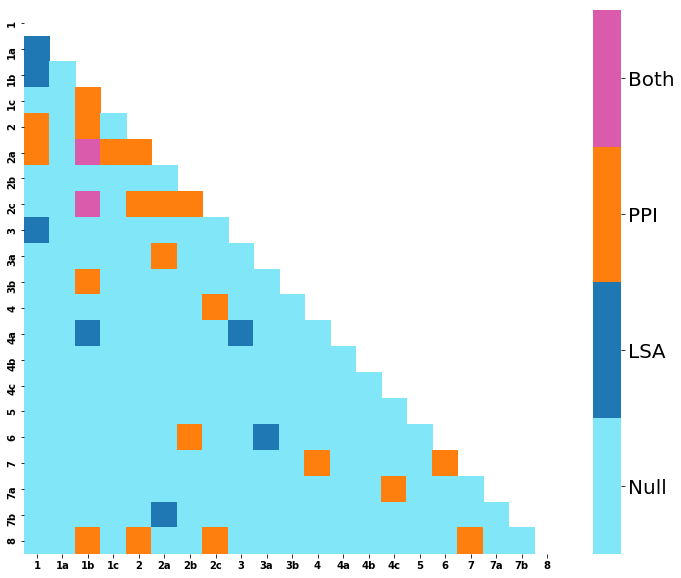

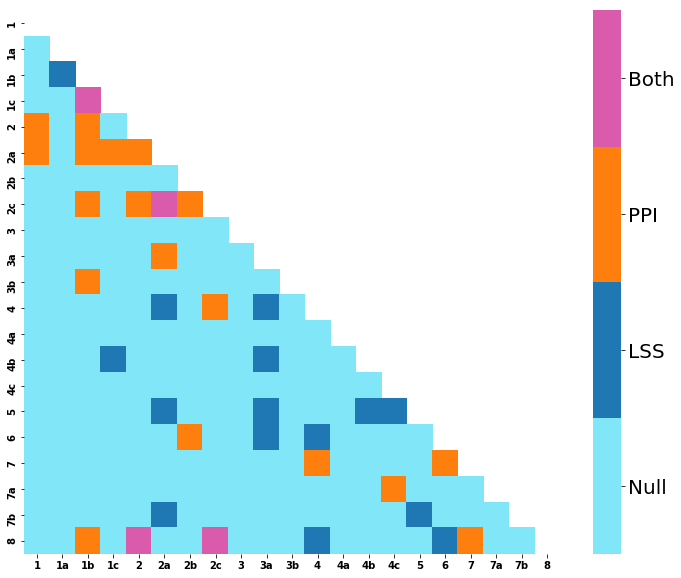

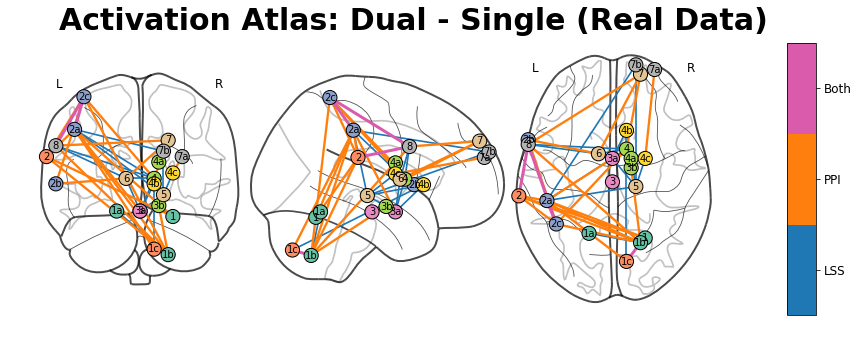

In [22]:
analyze_data(
    ts_act_ppi_dualxsingle,
    ts_act_lss_dualxsingle,
    ts_act_lsa_dualxsingle,
    "real",
    result_collector,
    correlation_collector,
    "dualxsingle",
    "activation",
    coords_df,
)

## Activation Atlas: Dual - Single (Null Data)

Number of Positives lsa: 11 / 210
Number of Positives ppi: 20 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 9 / 210
Number of Positives ppi: 20 / 210
Number of overlapping positives: 4 / 210
[[1.         0.43325683 0.42297513]
 [0.43325683 1.         0.70047518]
 [0.42297513 0.70047518 1.        ]]


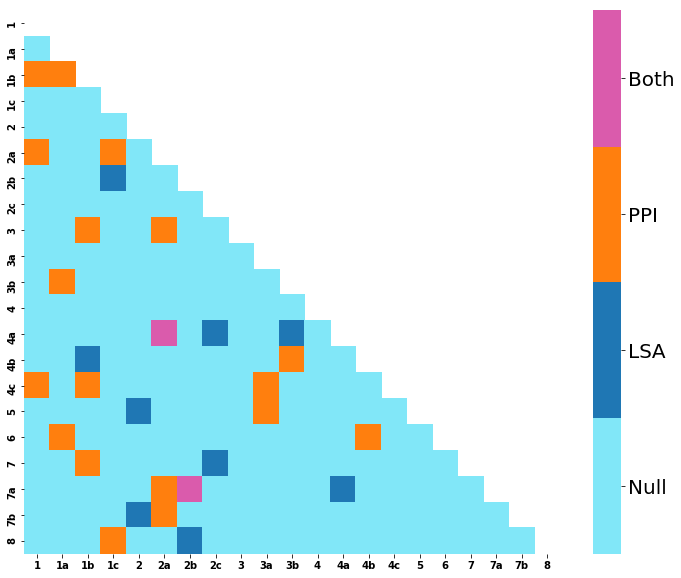

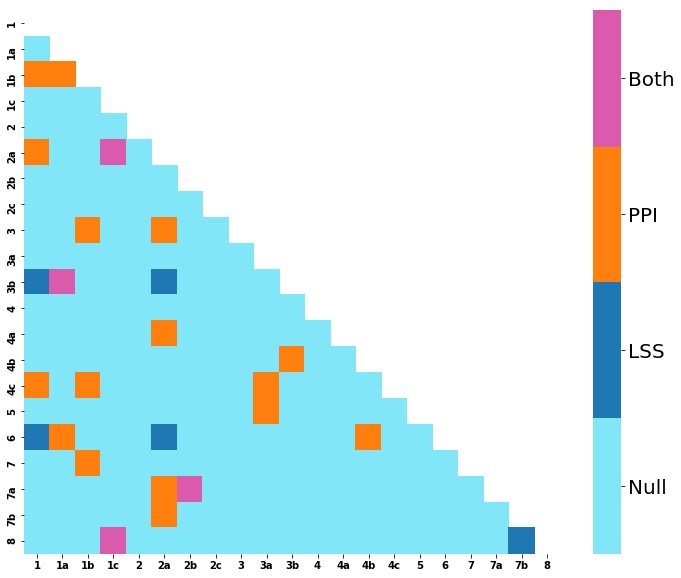

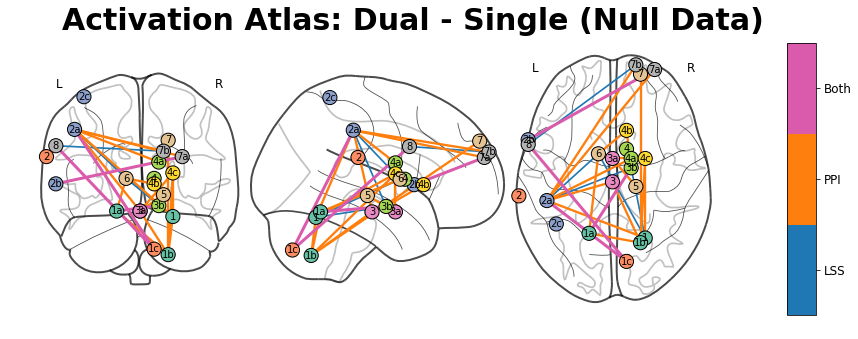

In [23]:
analyze_data(
    fb_act_ppi_dualxsingle,
    fb_act_lss_dualxsingle,
    fb_act_lsa_dualxsingle,
    "null",
    result_collector,
    correlation_collector,
    "dualxsingle",
    "activation",
    coords_df,
)

## Activation Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 21 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210
Number of Positives lss: 16 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210
[[1.         0.31260691 0.22934983]
 [0.31260691 1.         0.56167524]
 [0.22934983 0.56167524 1.        ]]


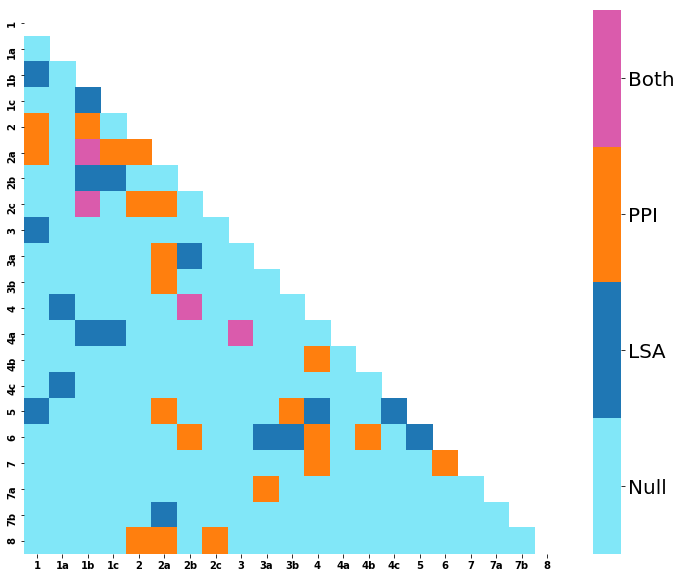

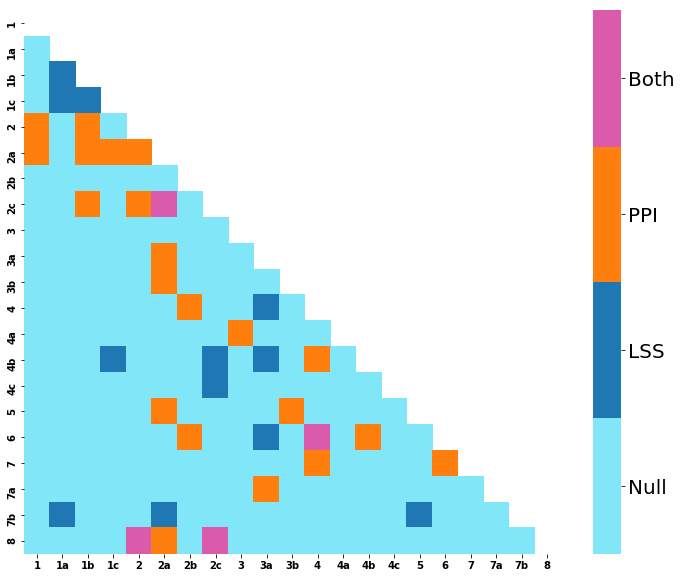

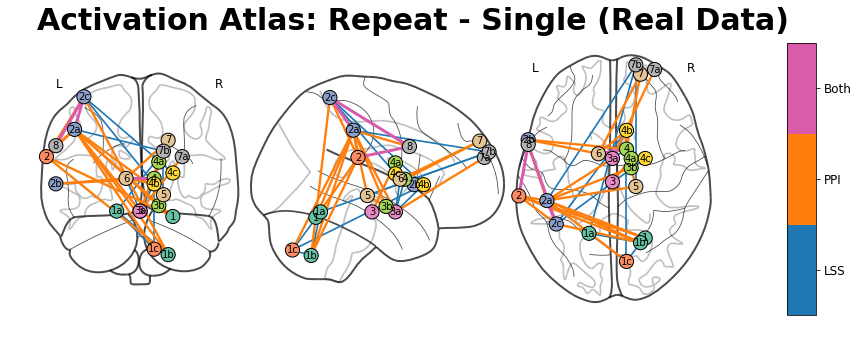

In [24]:
analyze_data(
    ts_act_ppi_repeatxsingle,
    ts_act_lss_repeatxsingle,
    ts_act_lsa_repeatxsingle,
    "real",
    result_collector,
    correlation_collector,
    "repeatxsingle",
    "activation",
    coords_df,
)

## Activation Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 10 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 12 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 5 / 210
[[1.         0.440006   0.39759459]
 [0.440006   1.         0.69317566]
 [0.39759459 0.69317566 1.        ]]


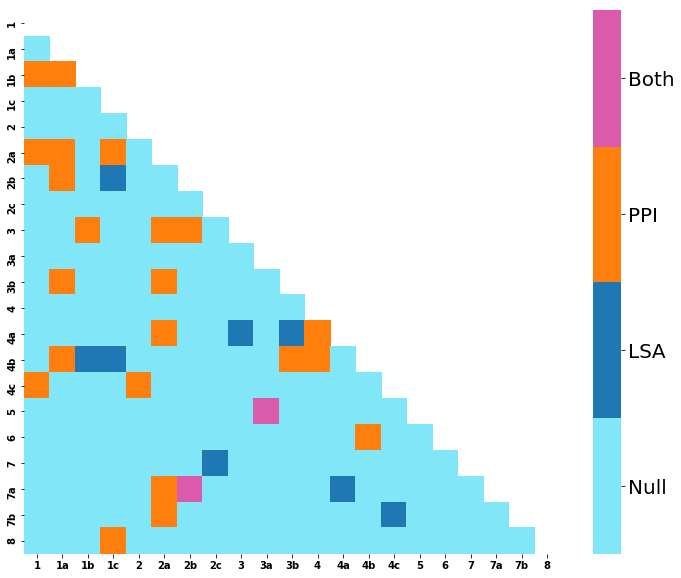

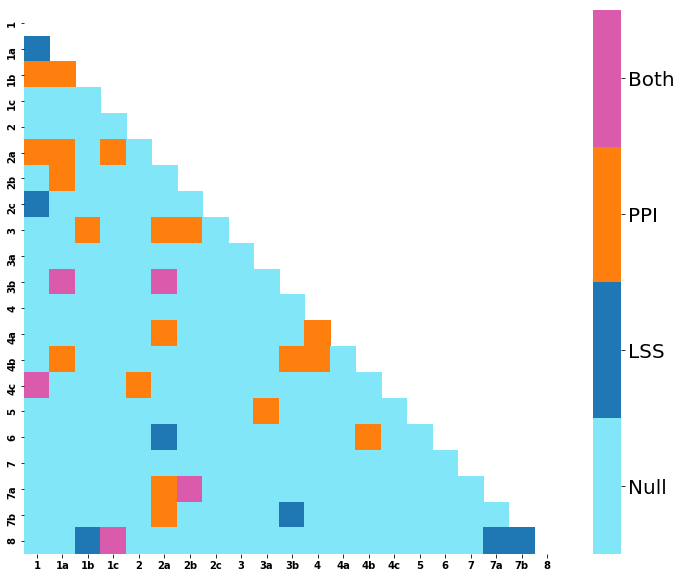

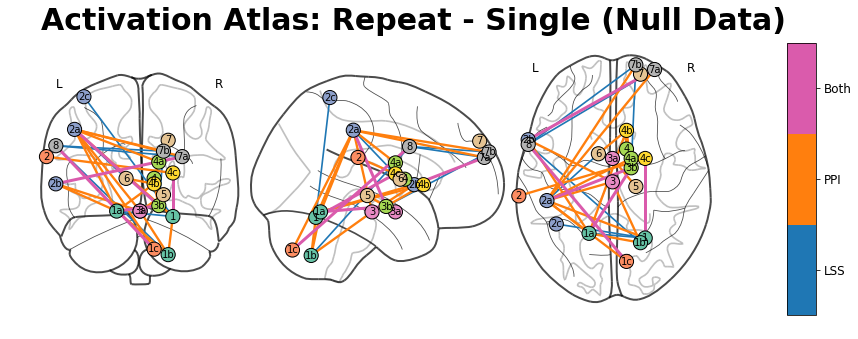

In [25]:
analyze_data(
    fb_act_ppi_repeatxsingle,
    fb_act_lss_repeatxsingle,
    fb_act_lsa_repeatxsingle,
    "null",
    result_collector,
    correlation_collector,
    "repeatxsingle",
    "activation",
    coords_df,
)

## Activation Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 15 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 6 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 1 / 210
[[1.         0.29343153 0.22671906]
 [0.29343153 1.         0.47083959]
 [0.22671906 0.47083959 1.        ]]


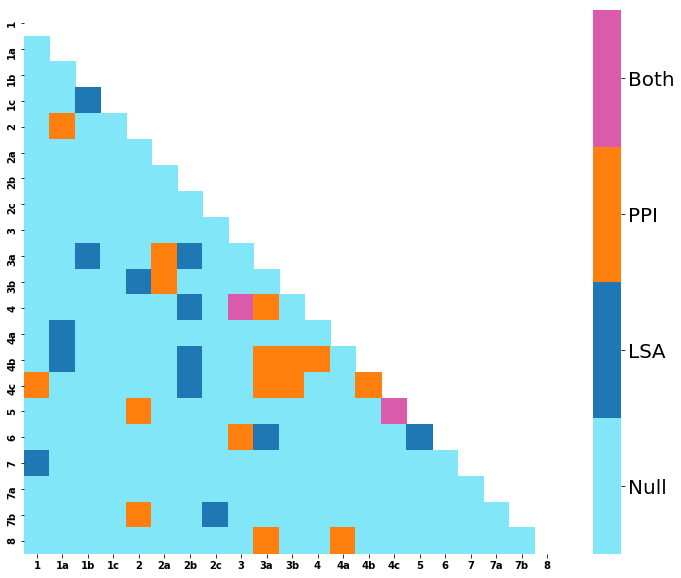

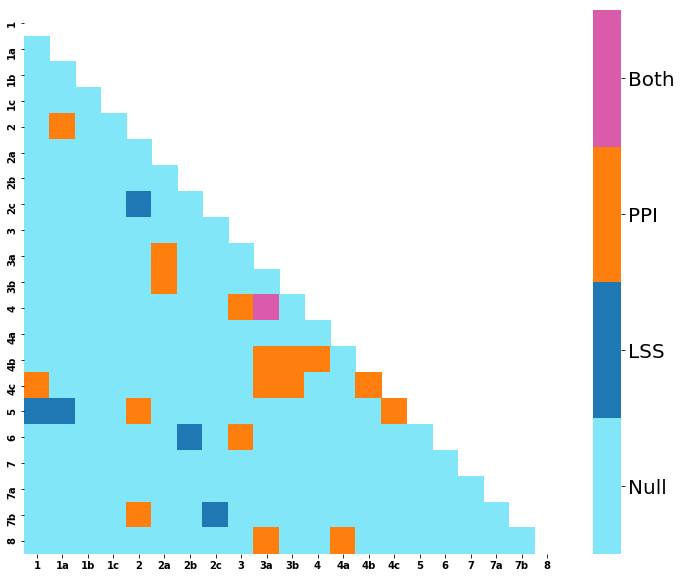

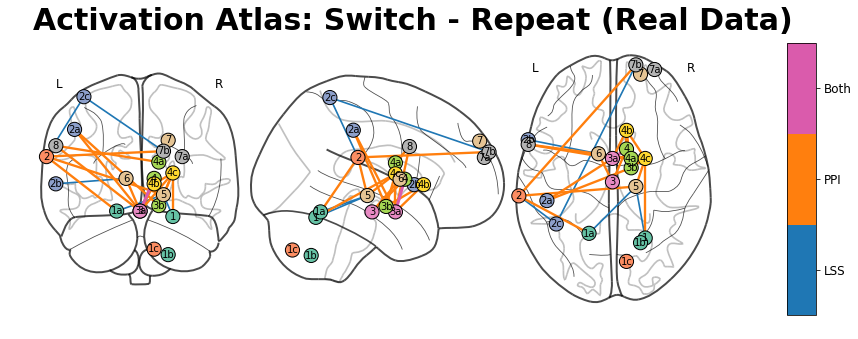

In [26]:
analyze_data(
    ts_act_ppi_switchxrepeat,
    ts_act_lss_switchxrepeat,
    ts_act_lsa_switchxrepeat,
    "real",
    result_collector,
    correlation_collector,
    "switchxrepeat",
    "activation",
    coords_df,
)

## Activation Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 12 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210
Number of Positives lss: 3 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210
[[1.         0.24442152 0.25035555]
 [0.24442152 1.         0.43974041]
 [0.25035555 0.43974041 1.        ]]


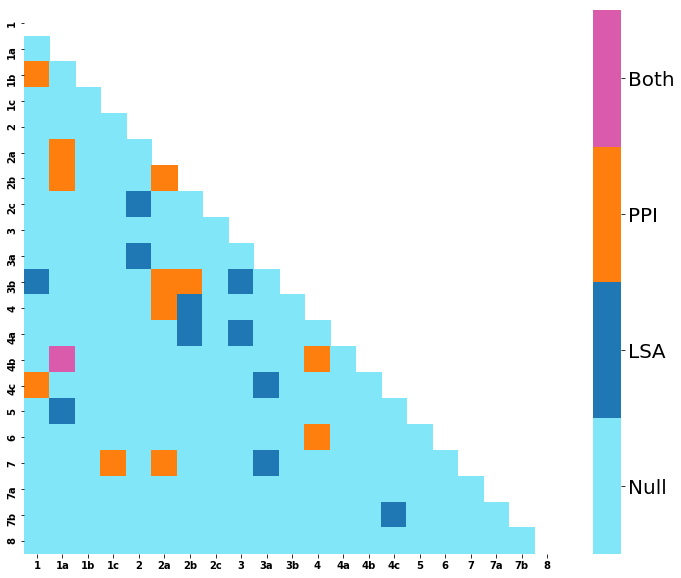

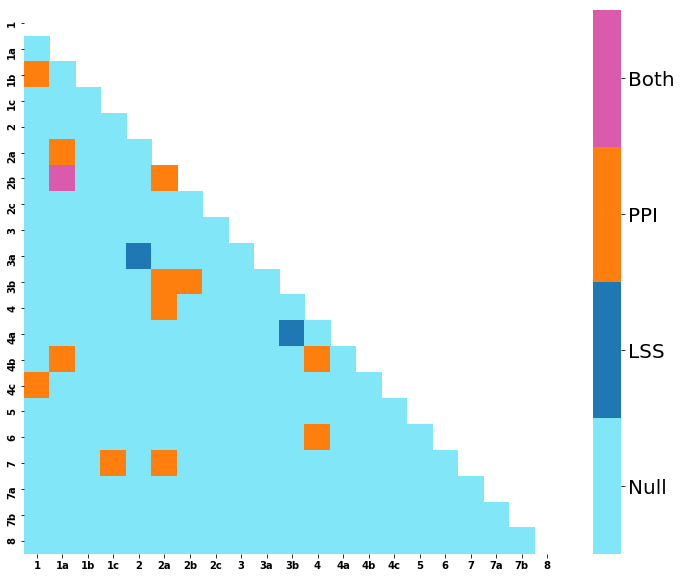

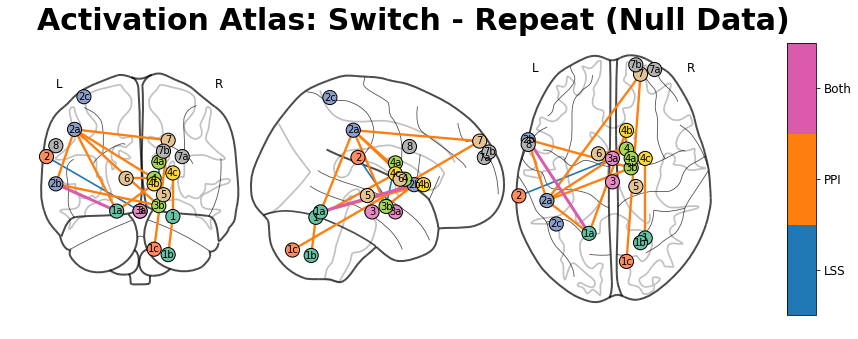

In [27]:
analyze_data(
    fb_act_ppi_switchxrepeat,
    fb_act_lss_switchxrepeat,
    fb_act_lsa_switchxrepeat,
    "null",
    result_collector,
    correlation_collector,
    "switchxrepeat",
    "activation",
    coords_df,
)

## Schaefer Analysis Prep

In [28]:
# regions with the best CNR
import pickle
with open('../nibsAnalysis/outputs/schaefer_best_cnr.pkl', "rb") as fp:
    best_regions_orig = pickle.load(fp)
best_regions = [nf._flip_hemisphere_network(w) for w in best_regions_orig]
best_regions.sort()
best_regions

['ContA-LH_IPS_1',
 'DefaultA-LH_PCC_6',
 'DefaultC-LH_PHC_1',
 'Limbic-LH_OFC_3',
 'Limbic-LH_TempPole_2',
 'Limbic-LH_TempPole_7',
 'Limbic-RH_OFC_3',
 'Limbic-RH_OFC_5',
 'Limbic-RH_TempPole_5',
 'VisCent-LH_ExStr_3',
 'VisCent-LH_ExStr_4',
 'VisCent-LH_ExStr_5',
 'VisCent-LH_ExStr_7',
 'VisCent-RH_ExStr_2',
 'VisCent-RH_ExStr_4',
 'VisCent-RH_ExStr_5',
 'VisCent-RH_ExStr_6',
 'VisCent-RH_ExStr_7',
 'VisCent-RH_ExStr_9',
 'VisPeri-LH_ExStrSup_6']

In [29]:
names = ["ROI Index", "Label Name", "r", "g", "b", "a"]
schaefer_color_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_400Parcels_17Networks_order.txt"
schaefer_color_lut = pd.read_csv(schaefer_color_fname, names=names, sep='\t')

schaefer_atlas_centroid_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv"
schaefer_centroid_coords = pd.read_csv(schaefer_atlas_centroid_fname)

schaefer_info = pd.merge(schaefer_centroid_coords, schaefer_color_lut, on=["ROI Index", "Label Name"], how="inner")

schaefer_info.replace(
    r'17Networks_([RL]H)_([A-Za-z]+)_([A-Za-z]+)_([0-9]+)',
    r'\1-\2-\3_\4',
    regex=True,
    inplace=True)

schaeferbest_info = schaefer_info[schaefer_info['Label Name'].isin(best_regions_orig)]
schaeferbest_info.rename(columns={"R": "X", "A": "Y", "S": "Z"}, inplace=True)
schaeferbest_info['best_regions'] = schaeferbest_info["Label Name"].apply(nf._flip_hemisphere_network)
schaeferbest_info.sort_values(by='best_regions', inplace=True)
schaeferbest_info

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

,ROI Index,Label Name,X,Y,Z,r,g,b,a,best_regions
121,122,LH-ContA-IPS_1,-29.0,-74.0,42.0,230,148,34,0,ContA-LH_IPS_1
158,159,LH-DefaultA-PCC_6,-3.0,-68.0,41.0,255,254,6,0,DefaultA-LH_PCC_6
191,192,LH-DefaultC-PHC_1,-21.0,-21.0,-26.0,0,1,131,0,DefaultC-LH_PHC_1
110,111,LH-Limbic-OFC_3,-10.0,47.0,-21.0,122,135,52,0,Limbic-LH_OFC_3
114,115,LH-Limbic-TempPole_2,-25.0,6.0,-39.0,220,248,163,0,Limbic-LH_TempPole_2
119,120,LH-Limbic-TempPole_7,-44.0,5.0,-17.0,220,248,169,0,Limbic-LH_TempPole_7
314,315,RH-Limbic-OFC_3,8.0,47.0,-23.0,126,135,53,0,Limbic-RH_OFC_3
316,317,RH-Limbic-OFC_5,5.0,22.0,-21.0,126,135,55,0,Limbic-RH_OFC_5
322,323,RH-Limbic-TempPole_5,29.0,12.0,-30.0,224,248,169,0,Limbic-RH_TempPole_5
2,3,LH-VisCent-ExStr_3,-36.0,-81.0,-16.0,120,18,133,0,VisCent-LH_ExStr_3


## Schaefer Atlas: Dual - Single (Real Data)

Number of Positives lsa: 8069 / 79800
Number of Positives ppi: 13362 / 79800
Number of overlapping positives: 2016 / 79800
Number of Positives lss: 7723 / 79800
Number of Positives ppi: 13362 / 79800
Number of overlapping positives: 3636 / 79800
Schaefer Top 20
[[1.         0.51478932 0.31476519]
 [0.51478932 1.         0.59088478]
 [0.31476519 0.59088478 1.        ]]
Schaefer Full
[[1.         0.37685651 0.26604449]
 [0.37685651 1.         0.57812522]
 [0.26604449 0.57812522 1.        ]]


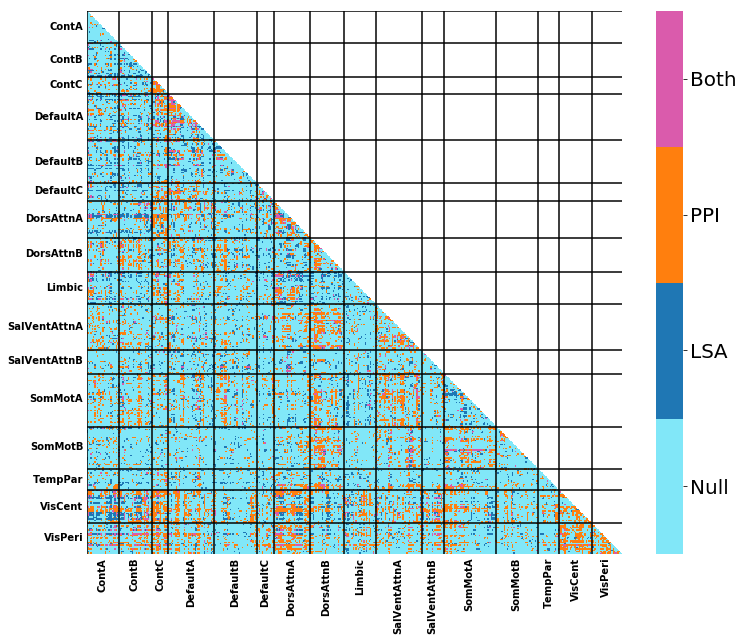

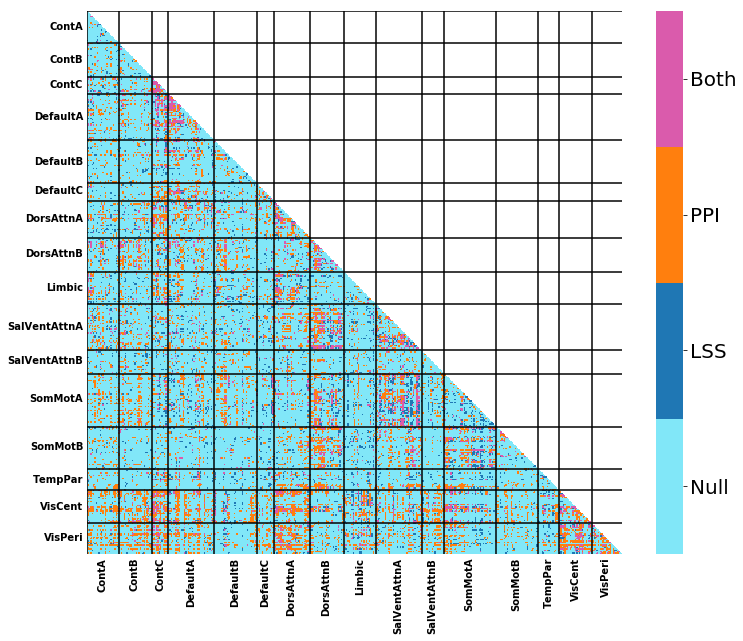

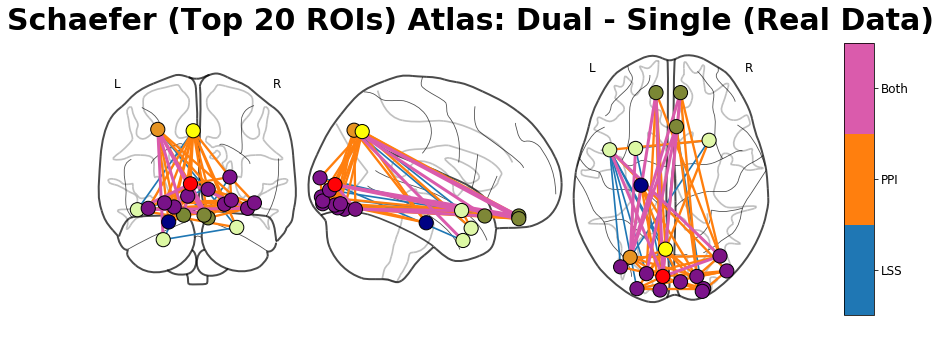

In [30]:
analyze_data(
    ts_sch_ppi_dualxsingle,
    ts_sch_lss_dualxsingle,
    ts_sch_lsa_dualxsingle,
    "real",
    result_collector,
    correlation_collector,
    "dualxsingle",
    "schaefer",
    schaeferbest_info,
    best_regions=best_regions,
    best_regions_orig=best_regions_orig,
)

## Schaefer Atlas: Dual - Single (Null Data)

Number of Positives lsa: 6384 / 79800
Number of Positives ppi: 11184 / 79800
Number of overlapping positives: 1705 / 79800
Number of Positives lss: 8213 / 79800
Number of Positives ppi: 11184 / 79800
Number of overlapping positives: 3640 / 79800
Schaefer Top 20
[[1.         0.27815947 0.27041696]
 [0.27815947 1.         0.60456574]
 [0.27041696 0.60456574 1.        ]]
Schaefer Full
[[1.         0.46815158 0.42036584]
 [0.46815158 1.         0.6868498 ]
 [0.42036584 0.6868498  1.        ]]


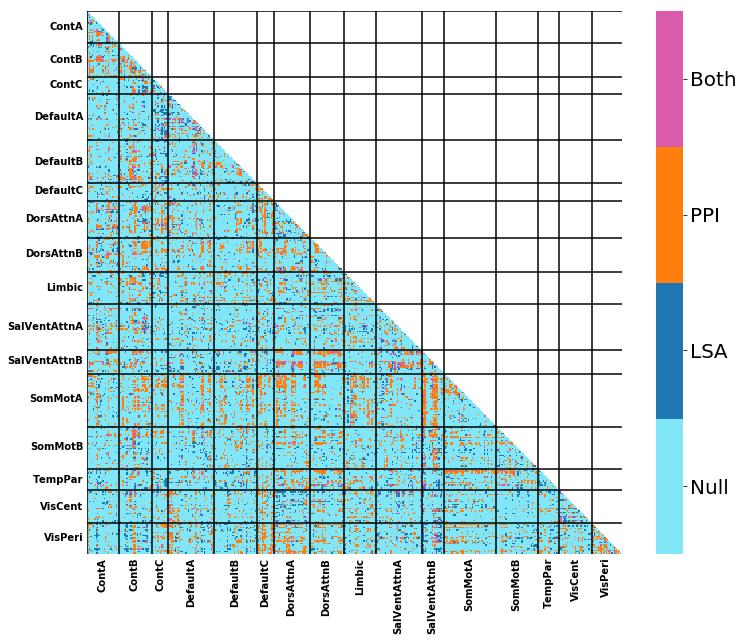

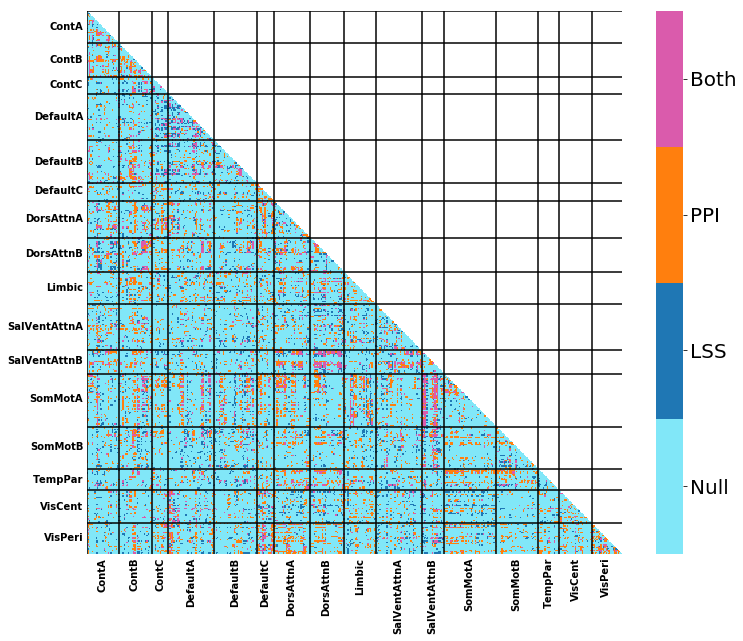

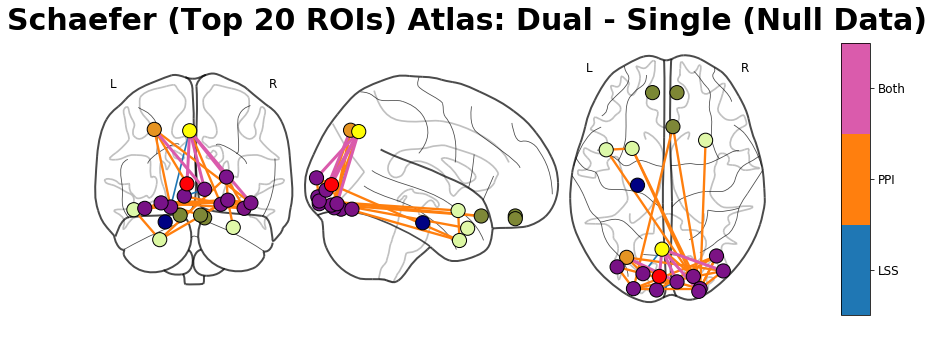

In [31]:
analyze_data(
    fb_sch_ppi_dualxsingle,
    fb_sch_lss_dualxsingle,
    fb_sch_lsa_dualxsingle,
    "null",
    result_collector,
    correlation_collector,
    "dualxsingle",
    "schaefer",
    schaeferbest_info,
    best_regions=best_regions,
    best_regions_orig=best_regions_orig,
)

## Schaefer Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 9145 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 2140 / 79800
Number of Positives lss: 7631 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 3773 / 79800
Schaefer Top 20
[[1.         0.52712353 0.42064284]
 [0.52712353 1.         0.67288394]
 [0.42064284 0.67288394 1.        ]]
Schaefer Full
[[1.         0.36220345 0.2700873 ]
 [0.36220345 1.         0.61879456]
 [0.2700873  0.61879456 1.        ]]


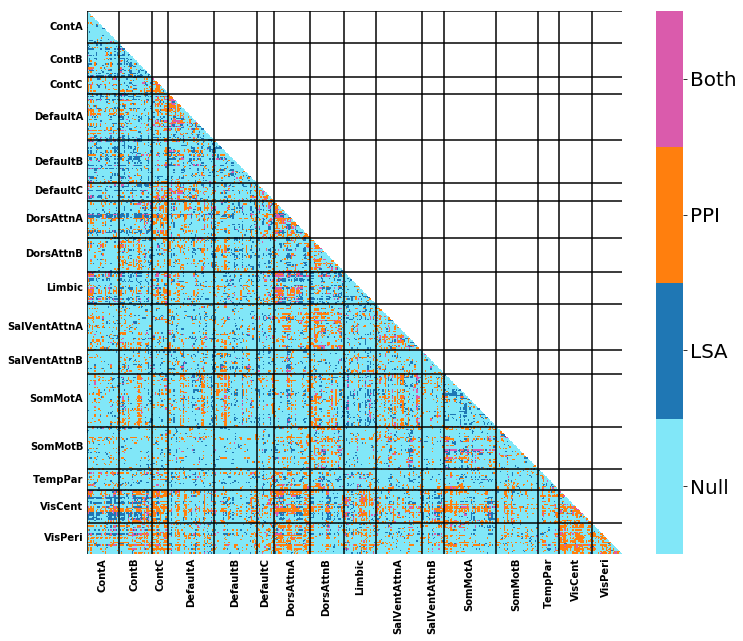

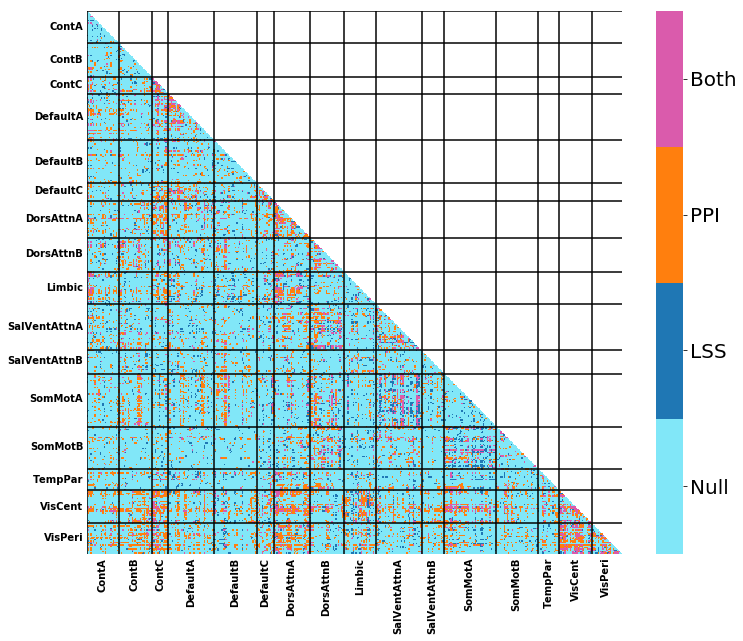

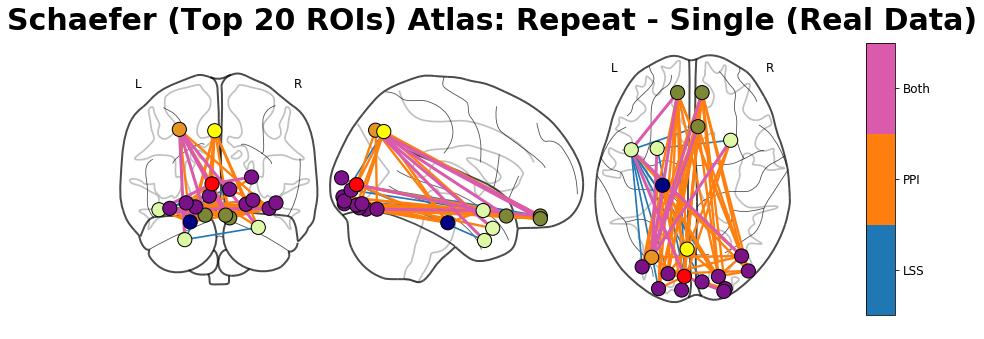

In [32]:
analyze_data(
    ts_sch_ppi_repeatxsingle,
    ts_sch_lss_repeatxsingle,
    ts_sch_lsa_repeatxsingle,
    "real",
    result_collector,
    correlation_collector,
    "repeatxsingle",
    "schaefer",
    schaeferbest_info,
    best_regions=best_regions,
    best_regions_orig=best_regions_orig,
)

## Schaefer Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 6762 / 79800
Number of Positives ppi: 11375 / 79800
Number of overlapping positives: 1896 / 79800
Number of Positives lss: 8461 / 79800
Number of Positives ppi: 11375 / 79800
Number of overlapping positives: 4089 / 79800
Schaefer Top 20
[[1.         0.13824622 0.23725042]
 [0.13824622 1.         0.69201892]
 [0.23725042 0.69201892 1.        ]]
Schaefer Full
[[1.         0.46921821 0.41648274]
 [0.46921821 1.         0.70366855]
 [0.41648274 0.70366855 1.        ]]


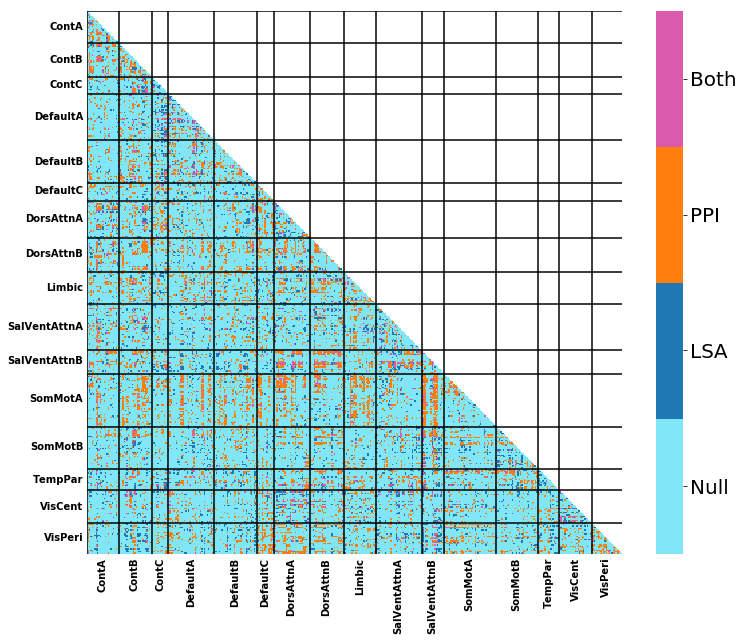

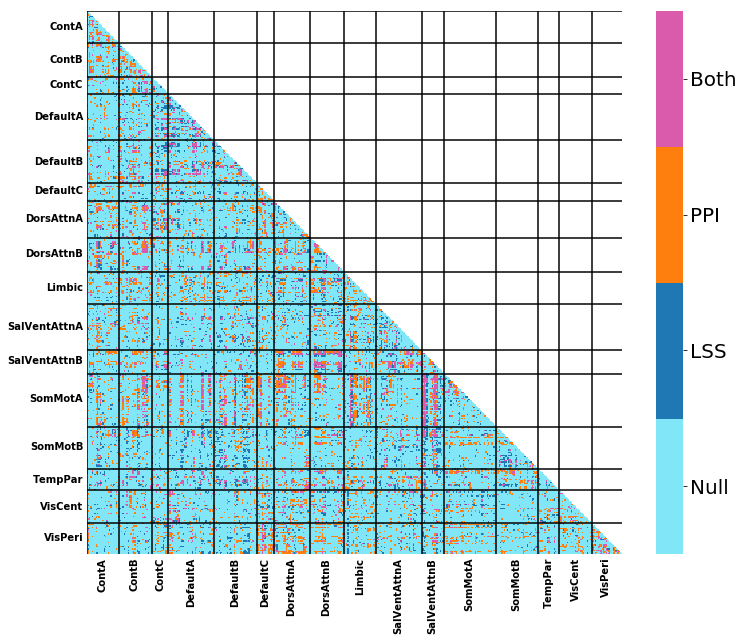

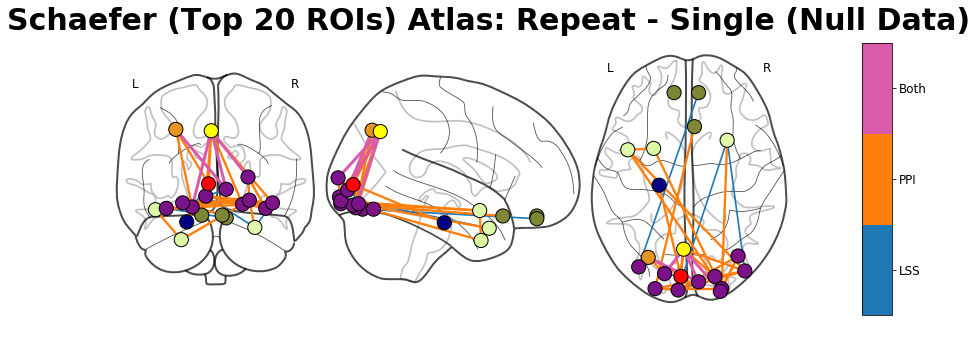

In [33]:
analyze_data(
    fb_sch_ppi_repeatxsingle,
    fb_sch_lss_repeatxsingle,
    fb_sch_lsa_repeatxsingle,
    "null",
    result_collector,
    correlation_collector,
    "repeatxsingle",
    "schaefer",
    schaeferbest_info,
    best_regions=best_regions,
    best_regions_orig=best_regions_orig,
)

## Schaefer Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 5153 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 388 / 79800
Number of Positives lss: 3462 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 406 / 79800
Schaefer Top 20
[[1.         0.25164114 0.22583531]
 [0.25164114 1.         0.17256221]
 [0.22583531 0.17256221 1.        ]]
Schaefer Full
[[1.         0.30009307 0.1683753 ]
 [0.30009307 1.         0.39020495]
 [0.1683753  0.39020495 1.        ]]


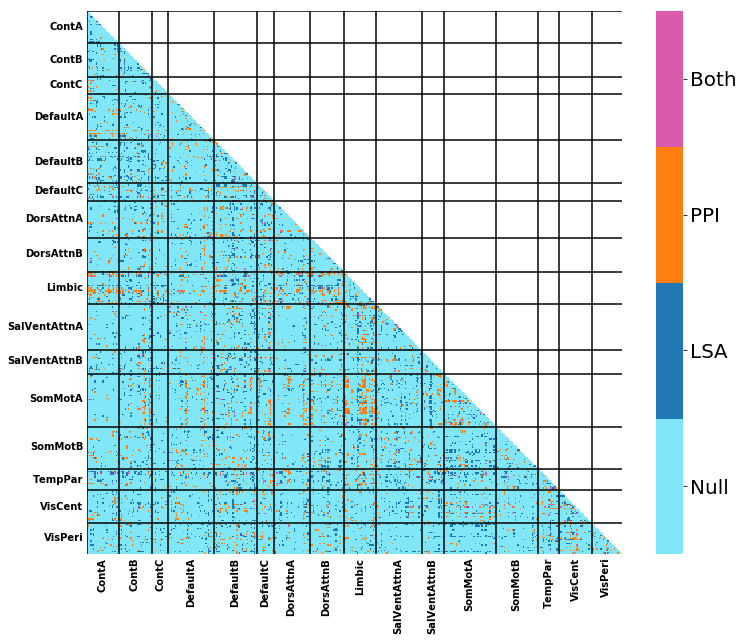

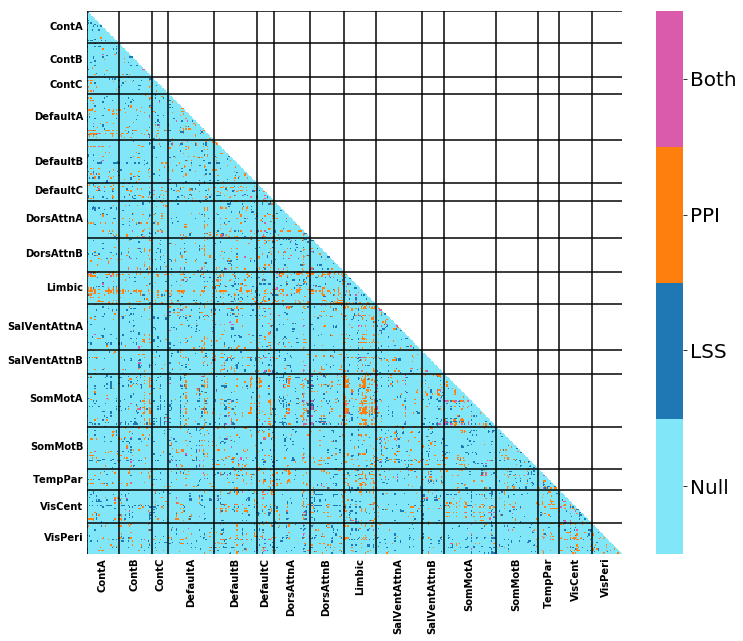

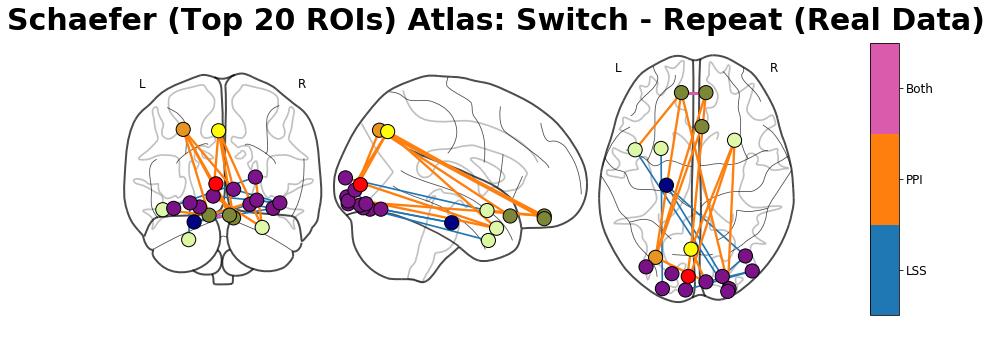

In [34]:
analyze_data(
    ts_sch_ppi_switchxrepeat,
    ts_sch_lss_switchxrepeat,
    ts_sch_lsa_switchxrepeat,
    "real",
    result_collector,
    correlation_collector,
    "switchxrepeat",
    "schaefer",
    schaeferbest_info,
    best_regions=best_regions,
    best_regions_orig=best_regions_orig,
)

## Schaefer Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 3904 / 79800
Number of Positives ppi: 5037 / 79800
Number of overlapping positives: 511 / 79800
Number of Positives lss: 4443 / 79800
Number of Positives ppi: 5037 / 79800
Number of overlapping positives: 779 / 79800
Schaefer Top 20
[[1.         0.20114675 0.19022264]
 [0.20114675 1.         0.35198298]
 [0.19022264 0.35198298 1.        ]]
Schaefer Full
[[1.         0.28500166 0.26550517]
 [0.28500166 1.         0.4138742 ]
 [0.26550517 0.4138742  1.        ]]


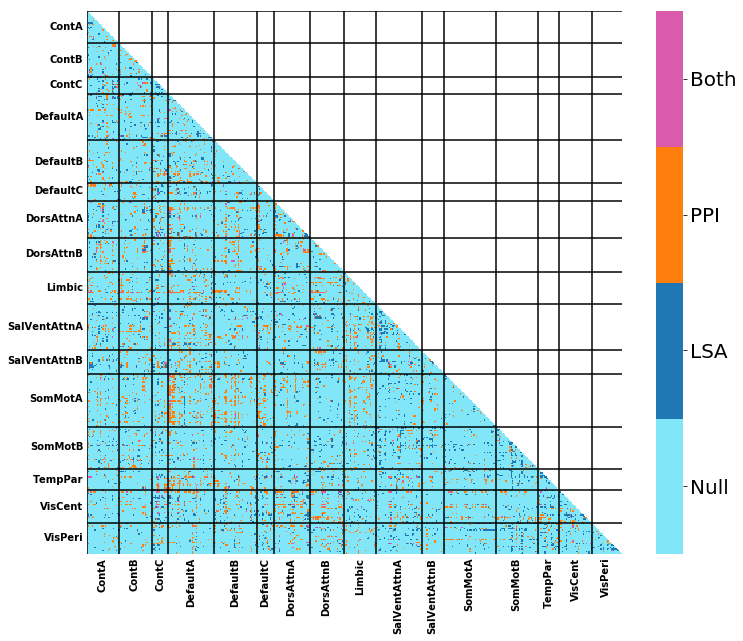

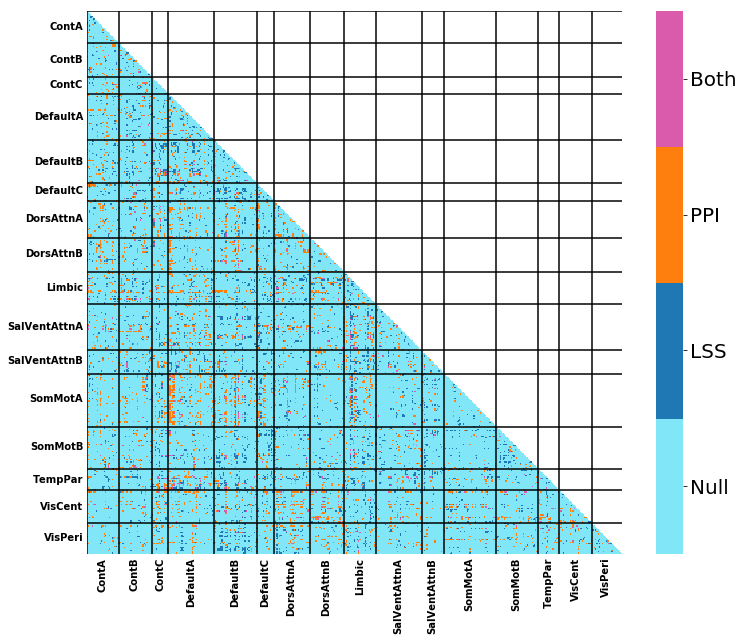

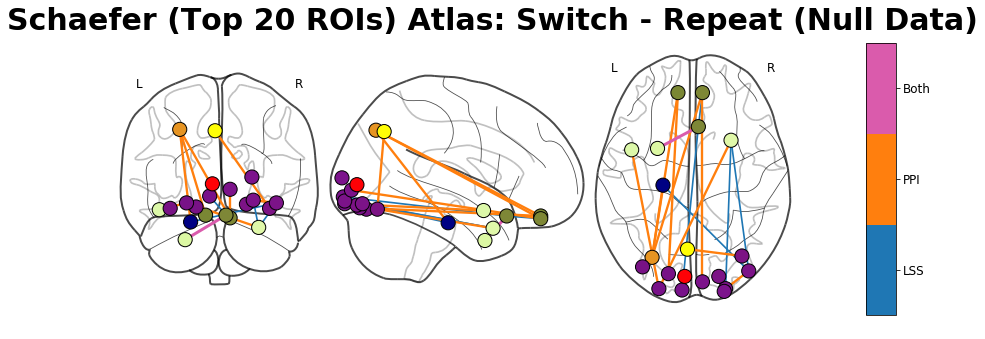

In [35]:
analyze_data(
    fb_sch_ppi_switchxrepeat,
    fb_sch_lss_switchxrepeat,
    fb_sch_lsa_switchxrepeat,
    "null",
    result_collector,
    correlation_collector,
    "switchxrepeat",
    "schaefer",
    schaeferbest_info,
    best_regions=best_regions,
    best_regions_orig=best_regions_orig,
)

## Analysis Overview

In [36]:
result_df = pd.DataFrame.from_dict(result_collector)
result_df.to_csv('./outputs/observed_significance_results.tsv', sep='\t')

In [37]:
result_df

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p
0,activation,real,dualxsingle,ppi,filtered,22,9.266853e-04,5.044984,9.901024e-07
1,activation,real,dualxsingle,lss,filtered,19,9.621226e-03,5.044984,9.901024e-07
2,activation,real,dualxsingle,lsa,filtered,9,7.270661e-01,5.044984,9.901024e-07
3,activation,null,dualxsingle,ppi,filtered,20,4.630043e-03,5.166868,5.586028e-07
4,activation,null,dualxsingle,lss,filtered,9,7.270661e-01,5.166868,5.586028e-07
5,activation,null,dualxsingle,lsa,filtered,11,4.808408e-01,5.166868,5.586028e-07
6,activation,real,repeatxsingle,ppi,filtered,25,5.885492e-05,4.842234,2.510241e-06
7,activation,real,repeatxsingle,lss,filtered,16,6.332235e-02,4.842234,2.510241e-06
8,activation,real,repeatxsingle,lsa,filtered,21,2.121317e-03,4.842234,2.510241e-06
9,activation,null,repeatxsingle,ppi,filtered,24,1.541505e-04,5.463554,1.332492e-07


In [50]:
contrast_order = ['dualxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss', 'ppi']
def make_summary_plots(contrast_order,
                       method_order,
                       permutation_df,
                       atlas,
                       data,
                       n_roi_roi_pairs,
                       participants="filtered"):
    
    # filter down to the relevant data
    query = "(data == '{data}') & (atlas == '{atlas}') & (participants == '{participants}')".format(
        data=data, atlas=atlas, participants=participants)
    
    permutation_filt_df = permutation_df.query(query)
    
    # create a percentage
    permutation_filt_df['observed_value_percent'] = (permutation_filt_df['observed_value'] / n_roi_roi_pairs) * 100

    # make the figure
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.swarmplot(x='contrast',
                  order=contrast_order,
                  y='observed_value_percent',
                  hue='estimator',
                  hue_order=method_order,
                  dodge=True,
                  size=15,
                  ax=ax,
                  data=permutation_filt_df)

    ax.set_ylim(0, 35)

    # create confidence interval
    lower_confidence, higher_confidence = proportion_confint(n_roi_roi_pairs*0.05, n_roi_roi_pairs)
    ax.axhspan(lower_confidence*100, higher_confidence*100, alpha=0.15,
               facecolor='red', edgecolor=None)

    # set y label
    ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)

    # set x label
    ax.set_xlabel("")

    # set x tick marks
    new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
    ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

    # change the alpha of the legend, and make text more visible
    [p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
    ax.legend_.set_title("")
    ax.legend_.texts[0].set(size=12, weight='bold')

    # draw false positive line
    ax.axhline(5, color='red', linestyle='--', linewidth=3)
    ax.text(ax.get_xlim()[0] + 0.01, 3.5, "Expected False Positive Rate (5%)", weight='heavy');

    # separate the dot pairs
    category_xval = (ax.get_xticks() + 0.5)[0:-1]
    for xval in category_xval:
        ax.axvline(xval, color='black')

    # change the alpha of the violins
    contrast_orders = [item for item in contrast_order for i in range(len(method_order))]
    method_orders = method_order * len(contrast_order)

    # annotate dots with p-values
    for contrast, method, point in zip(contrast_orders, method_orders, ax.collections[:len(contrast_order) * len(method_order)]):
        df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
        p_val = permutation_filt_df.query(df_query)['binom_p_value'].unique()[0]
        # import pdb; pdb.set_trace()
        p_val_round = round(p_val, 3)

        if p_val_round == 0:
            p_str = 'p<{:.3f}'.format(p_val_round + 0.001)
        else:
            p_str = 'p={:.3f}'.format(p_val_round)

        # bold significant p-value
        if p_val < 0.05:
            weight = 'bold'
        else:
            weight = 'normal'

        coordinates = point.get_offsets()
        x_text, y = coordinates[0, 0], coordinates[0, 1]
        if y < 4.5 and y > 3.5:
            y_offset = -1.9
        else:
            y_offset = 1.4
        y_text = y + y_offset
        ax.text(x_text, y_text, p_str, ha='center', size=11, weight=weight)


    # make title
    atlas_dict = {
        "activation": "Activation Atlas",
        "schaefer": "Schaefer Atlas",
        "schaeferbest": "Schaefer (Top 20 ROIs)",
    }
    
    data_dict = {
        "null": "Null",
        "real": "Real",
    }
        
    fig.suptitle("{atlas}: {data} Data".format(atlas=atlas_dict[atlas],
                                               data=data_dict[data]),
                size=20,
                weight="heavy")
    return fig, permutation_filt_df

### Activation Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


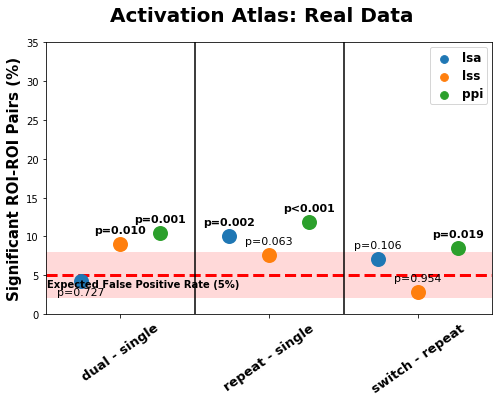

In [51]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "activation", "real", 210)
save_eps(fig, 'outputs/data-real_atlas-activation_participants-filtered_permutation_summary_ppi')

In [52]:
pfd

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p,observed_value_percent
0,activation,real,dualxsingle,ppi,filtered,22,0.000927,5.044984,9.901024e-07,10.476190
1,activation,real,dualxsingle,lss,filtered,19,0.009621,5.044984,9.901024e-07,9.047619
2,activation,real,dualxsingle,lsa,filtered,9,0.727066,5.044984,9.901024e-07,4.285714
6,activation,real,repeatxsingle,ppi,filtered,25,0.000059,4.842234,2.510241e-06,11.904762
7,activation,real,repeatxsingle,lss,filtered,16,0.063322,4.842234,2.510241e-06,7.619048
8,activation,real,repeatxsingle,lsa,filtered,21,0.002121,4.842234,2.510241e-06,10.000000
12,activation,real,switchxrepeat,ppi,filtered,18,0.019006,3.317922,1.071301e-03,8.571429
13,activation,real,switchxrepeat,lss,filtered,6,0.953639,3.317922,1.071301e-03,2.857143
14,activation,real,switchxrepeat,lsa,filtered,15,0.106486,3.317922,1.071301e-03,7.142857


### Activation Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


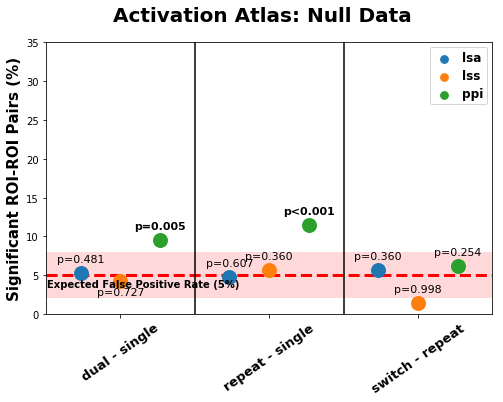

In [53]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "activation", "null", 210)
save_eps(fig, 'outputs/data-null_atlas-activation_participants-filtered_permutation_summary_ppi')

In [54]:
pfd

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p,observed_value_percent
3,activation,null,dualxsingle,ppi,filtered,20,0.004630,5.166868,5.586028e-07,9.523810
4,activation,null,dualxsingle,lss,filtered,9,0.727066,5.166868,5.586028e-07,4.285714
5,activation,null,dualxsingle,lsa,filtered,11,0.480841,5.166868,5.586028e-07,5.238095
9,activation,null,repeatxsingle,ppi,filtered,24,0.000154,5.463554,1.332492e-07,11.428571
10,activation,null,repeatxsingle,lss,filtered,12,0.359715,5.463554,1.332492e-07,5.714286
11,activation,null,repeatxsingle,lsa,filtered,10,0.607417,5.463554,1.332492e-07,4.761905
15,activation,null,switchxrepeat,ppi,filtered,13,0.253996,2.459837,1.471981e-02,6.190476
16,activation,null,switchxrepeat,lss,filtered,3,0.998471,2.459837,1.471981e-02,1.428571
17,activation,null,switchxrepeat,lsa,filtered,12,0.359715,2.459837,1.471981e-02,5.714286


### Schaeferbest Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


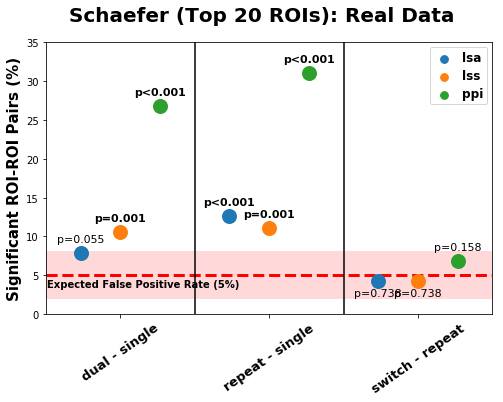

In [55]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaeferbest", "real", 190)
save_eps(fig, 'outputs/data-real_atlas-schaeferbest_participants-filtered_permutation_summary_ppi')

In [56]:
pfd

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p,observed_value_percent
18,schaeferbest,real,dualxsingle,ppi,filtered,51,2.684518e-23,4.695134,0.000005,26.842105
19,schaeferbest,real,dualxsingle,lss,filtered,20,1.452794e-03,4.695134,0.000005,10.526316
20,schaeferbest,real,dualxsingle,lsa,filtered,15,5.520896e-02,4.695134,0.000005,7.894737
30,schaeferbest,real,repeatxsingle,ppi,filtered,59,1.948790e-30,4.727675,0.000004,31.052632
31,schaeferbest,real,repeatxsingle,lss,filtered,21,5.989147e-04,4.727675,0.000004,11.052632
32,schaeferbest,real,repeatxsingle,lsa,filtered,24,3.146980e-05,4.727675,0.000004,12.631579
42,schaeferbest,real,switchxrepeat,ppi,filtered,13,1.581039e-01,-0.613044,0.540592,6.842105
43,schaeferbest,real,switchxrepeat,lss,filtered,8,7.379910e-01,-0.613044,0.540592,4.210526
44,schaeferbest,real,switchxrepeat,lsa,filtered,8,7.379910e-01,-0.613044,0.540592,4.210526


### Schaeferbest Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


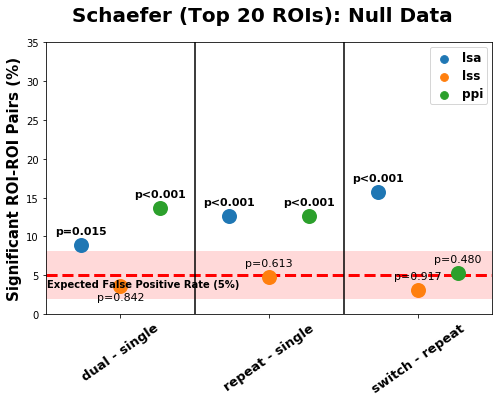

In [57]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaeferbest", "null", 190)
save_eps(fig, 'outputs/data-null_atlas-schaeferbest_participants-filtered_permutation_summary_ppi')

In [58]:
pfd

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p,observed_value_percent
24,schaeferbest,null,dualxsingle,ppi,filtered,26,3.523359e-06,4.674898,5.617094e-06,13.684211
25,schaeferbest,null,dualxsingle,lss,filtered,7,8.418625e-01,4.674898,5.617094e-06,3.684211
26,schaeferbest,null,dualxsingle,lsa,filtered,17,1.520590e-02,4.674898,5.617094e-06,8.947368
36,schaeferbest,null,repeatxsingle,ppi,filtered,24,3.146980e-05,6.272384,2.407574e-09,12.631579
37,schaeferbest,null,repeatxsingle,lss,filtered,9,6.129351e-01,6.272384,2.407574e-09,4.736842
38,schaeferbest,null,repeatxsingle,lsa,filtered,24,3.146980e-05,6.272384,2.407574e-09,12.631579
48,schaeferbest,null,switchxrepeat,ppi,filtered,10,4.798347e-01,1.864937,6.375693e-02,5.263158
49,schaeferbest,null,switchxrepeat,lss,filtered,6,9.169436e-01,1.864937,6.375693e-02,3.157895
50,schaeferbest,null,switchxrepeat,lsa,filtered,30,2.686470e-08,1.864937,6.375693e-02,15.789474


### Schaefer Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


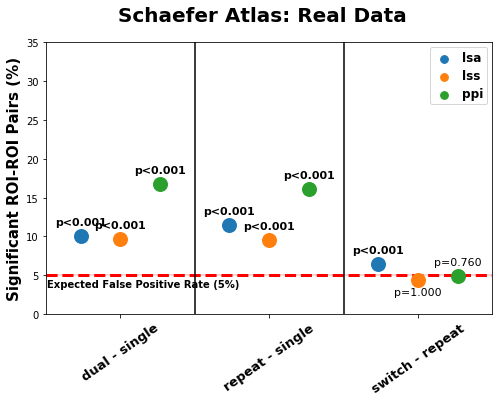

In [59]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaefer", "real", 79800)
save_eps(fig, 'outputs/data-real_atlas-schaefer_participants-filtered_permutation_summary_ppi')

In [60]:
pfd

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p,observed_value_percent
21,schaefer,real,dualxsingle,ppi,filtered,13362,0.000000e+00,95.191398,0.0,16.744361
22,schaefer,real,dualxsingle,lss,filtered,7723,0.000000e+00,95.191398,0.0,9.677945
23,schaefer,real,dualxsingle,lsa,filtered,8069,0.000000e+00,95.191398,0.0,10.111529
33,schaefer,real,repeatxsingle,ppi,filtered,12895,0.000000e+00,108.668367,0.0,16.159148
34,schaefer,real,repeatxsingle,lss,filtered,7631,0.000000e+00,108.668367,0.0,9.562657
35,schaefer,real,repeatxsingle,lsa,filtered,9145,0.000000e+00,108.668367,0.0,11.459900
45,schaefer,real,switchxrepeat,ppi,filtered,3947,7.596967e-01,57.127241,0.0,4.946115
46,schaefer,real,switchxrepeat,lss,filtered,3462,1.000000e+00,57.127241,0.0,4.338346
47,schaefer,real,switchxrepeat,lsa,filtered,5153,1.380611e-73,57.127241,0.0,6.457393


### SchaeferAtlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


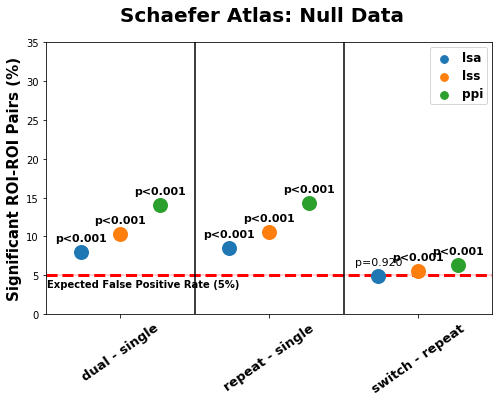

In [61]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaefer", "null", 79800)
save_eps(fig, 'outputs/data-null_atlas-schaefer_participants-filtered_permutation_summary_ppi')

In [62]:
pfd

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value,corr_t,corr_p,observed_value_percent
27,schaefer,null,dualxsingle,ppi,filtered,11184,0.000000e+00,98.845152,0.0,14.015038
28,schaefer,null,dualxsingle,lss,filtered,8213,0.000000e+00,98.845152,0.0,10.291980
29,schaefer,null,dualxsingle,lsa,filtered,6384,1.339624e-282,98.845152,0.0,8.000000
39,schaefer,null,repeatxsingle,ppi,filtered,11375,0.000000e+00,108.629920,0.0,14.254386
40,schaefer,null,repeatxsingle,lss,filtered,8461,0.000000e+00,108.629920,0.0,10.602757
41,schaefer,null,repeatxsingle,lsa,filtered,6762,0.000000e+00,108.629920,0.0,8.473684
51,schaefer,null,switchxrepeat,ppi,filtered,5037,1.716500e-60,38.517940,0.0,6.312030
52,schaefer,null,switchxrepeat,lss,filtered,4443,2.479320e-13,38.517940,0.0,5.567669
53,schaefer,null,switchxrepeat,lsa,filtered,3904,9.203426e-01,38.517940,0.0,4.892231


## analyze correlation results

In [45]:
correlation_df = pd.DataFrame.from_dict(correlation_collector)
correlation_df.to_csv('./outputs/observed_correlation_results.tsv', sep='\t')
correlation_df

,atlas,data,contrast,participants,lssxppi,lsaxppi,lsaxlss,corr_t,corr_p
0,activation,real,dualxsingle,filtered,0.566391,0.220175,0.308514,5.044984,9.901024e-07
1,activation,null,dualxsingle,filtered,0.700475,0.422975,0.433257,5.166868,5.586028e-07
2,activation,real,repeatxsingle,filtered,0.561675,0.229350,0.312607,4.842234,2.510241e-06
3,activation,null,repeatxsingle,filtered,0.693176,0.397595,0.440006,5.463554,1.332492e-07
4,activation,real,switchxrepeat,filtered,0.470840,0.226719,0.293432,3.317922,1.071301e-03
5,activation,null,switchxrepeat,filtered,0.439740,0.250356,0.244422,2.459837,1.471981e-02
6,schaeferbest,real,dualxsingle,filtered,0.590885,0.314765,0.514789,4.695134,5.141918e-06
7,schaefer,real,dualxsingle,filtered,0.578125,0.266044,0.376857,95.191398,0.000000e+00
8,schaeferbest,null,dualxsingle,filtered,0.604566,0.270417,0.278159,4.674898,5.617094e-06
9,schaefer,null,dualxsingle,filtered,0.686850,0.420366,0.468152,98.845152,0.000000e+00


In [46]:
# mean lssxppi correlation
correlation_df.loc[:, 'lssxppi'].mean()

0.5504840735822804

In [47]:
# mean lsaxppi correlation
correlation_df.loc[:, 'lsaxppi'].mean()

0.2896201875422084

In [48]:
# mean lsaxlss correlation
correlation_df.loc[:, 'lsaxlss'].mean()

0.34471489306416153

In [49]:
# mean difference between lssxppi and lsaxppi
# (lss is more correlated with ppi than lsa)
correlation_df.loc[:, 'lssxppi'].mean() - correlation_df.loc[:, 'lsaxppi'].mean()

0.26086388604007194